In [13]:
# ---------------------------- Imports ----------------------------
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz

from herbie import Herbie

In [14]:
# ---------------------------- Constants ----------------------------

# Location to get temperature
LAT_STN = 40.7128
LON_STN = -74.0060
MEMBERS = [f"p{i:02d}" for i in range(1, 31)] + ["c00"]  # GEFS ensemble members

# Temperature ranges and labels
TEMP_RANGES = [
    (-np.inf, -15), (-15, -5), (-5, 32), (32, 50),
    (50, 70), (70, 95), (95, 105), (105, np.inf)
]
RANGE_LABELS = [
    "Extreme Cold Warning (< -15°F)", "Cold Weather Advisory (-15°F to -5°F)",
    "Cold to Freezing (-5°F to 32°F)", "Freezing to Cool (32°F to 50°F)",
    "Cool to Warm (50°F to 70°F)", "Warm to Hot (70°F to 95°F)",
    "Heat Advisory (95°F to 105°F)", "Excessive Heat Warning (> 105°F)"
]

import warnings

warnings.filterwarnings( # silence xarray timedelta warning
    "ignore",
    message=".*decode_timedelta will default to False.*",
    category=FutureWarning,
    module="cfgrib.xarray_plugin"
)

In [15]:
# ---------------------------- Functions ----------------------------

# Convert temperatures from Kelvin to Fahrenheit
def kelvin_to_fahrenheit(temps):
    """
    Convert temperatures from Kelvin to Fahrenheit.
    """
    return (temps - 273.15) * 9/5 + 32

# Get temperature for each member over a specified forecast period
def get_member_temperature_over_period(run_time, member, start_hour, end_hour):
    """
    Retrieve maximum and minimum temperatures for a given member over the forecast period.
    """
    temps = []
    
    for fxx in range(start_hour, end_hour + 1, 3):  # Loop over forecast hours in the range
        H = Herbie(run_time, model="gefs", product="atmos.5", member=member,
                   fxx=fxx, verbose=False)
        try:
            tmp_2m_ds = H.xarray("TMP:2 m") # Get 2m Temp dataset

            # If max longitude is greater than 180 (i.e., format is 0 to 360) then convert lon format from -180 to 180 to 0 to 360
            lon = LON_STN % 360 if tmp_2m_ds.longitude.max() > 180 else LON_STN

            # Get temperature values at chosen station
            temp_var = list(tmp_2m_ds.data_vars)[0]
            temp = tmp_2m_ds[temp_var].sel(latitude=LAT_STN, longitude=lon, method="nearest")
            
            # Store the max and min temperatures for the period
            temps.append(temp.values.item())

        except Exception as e:
            print(f"{member} failed at fxx={fxx}: {e}")
            return None, None

    # Get the max/min temperatures for the forecast period
    temp_max = max(temps)
    temp_min = min(temps)
    
    return temp_max, temp_min

# Retrieve the temperatures for all members within the user-specified forecast period
def get_forecast_temperatures(run_time, start_hour, end_hour):
    """
    Retrieve forecast temperatures over the given forecast period (start to end hour) for each member.
    """
    max_temps = []
    min_temps = []

    # Create list of max/min temps for each member
    for member in MEMBERS:
        print('member: ', member)
        max_temp, min_temp = get_member_temperature_over_period(run_time, member, start_hour, end_hour)
        if max_temp is not None and min_temp is not None:
            max_temps.append(max_temp)
            min_temps.append(min_temp)
    
    max_temps = np.array(max_temps)
    min_temps = np.array(min_temps)
    
    return max_temps, min_temps

# Calculate the percentage of members with max/min temperatures in each range
def calculate_percentages_in_ranges(temps, temp_ranges):
    """
    Calculate the percentage of members with max or min temperatures in each range.
    """
    percentages = {}
    for (lower, upper), label in zip(temp_ranges, RANGE_LABELS):
        in_range = ((temps >= lower) & (temps < upper)).sum()
        percentage = 100 * in_range / temps.size
        percentages[label] = round(percentage)
    return percentages

In [16]:
# Define colormap and normalization for background color
bg_cmap = plt.get_cmap("Greys")
norm_bg = mcolors.Normalize(vmin=0, vmax=130)

# Define text colors for table - based of NWS colors
text_colors = [
    (102/255, 90/255, 165/255),   # deep lavender
    (38/255, 10/255, 140/255),    # indigo
    (28/255, 98/255, 160/255),    # deep sky blue
    (110/255, 170/255, 205/255),  # light steel blue
    (200/255, 185/255, 110/255),  # muted gold
    (215/255, 145/255, 95/255),   # soft orange
    (192/255, 75/255, 80/255),    # coral red
    (160/255, 70/255, 95/255)     # dusky rose
]

# Plot the table with forecast valid time in title
def plot_table(df, run_time):
    """
    Create a table plot for the percentage data, with the forecast valid time in the title.
    """
    # Convert run_time_str to datetime object
    run_time_dt = datetime.datetime.strptime(run_time, "%Y-%m-%d %H:%M")
    
    # Calculate start and end times using hour offsets
    start_time_dt = run_time_dt + datetime.timedelta(hours=start_hour)
    end_time_dt = run_time_dt + datetime.timedelta(hours=end_hour)

    # Set up timezones
    utc_zone = pytz.utc
    local_zone = pytz.timezone('America/New_York')

    # Localize to UTC (i.e., make the datetime aware of UTC)
    run_time_dt = pytz.utc.localize(run_time_dt)
    start_time_dt = pytz.utc.localize(start_time_dt)
    end_time_dt = pytz.utc.localize(end_time_dt)

    # Convert times from UTC to local time
    run_time_dt_local = run_time_dt.astimezone(local_zone)
    start_time_dt_local = start_time_dt.astimezone(local_zone)
    end_time_dt_local = end_time_dt.astimezone(local_zone)
    
    # Format times as strings
    run_time_str_local = run_time_dt_local.strftime("%Y-%m-%d %H:%M")
    start_time_str_local = start_time_dt_local.strftime("%Y-%m-%d %H:%M")
    end_time_str_local = end_time_dt_local.strftime("%Y-%m-%d %H:%M")

    # Create the title with the valid time
    title = f"New York City, NY (KNYC) Temperatures\nValid: {start_time_str_local} to {end_time_str_local} Local Time"

    fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the figure size for a clearer table
    ax.axis("tight")
    ax.axis("off")

    # Create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc="center", colColours=["#f1f1f1"] * 4) # set default formatting
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    for (i, j), cell in table.get_celld().items():
        if i == 0:
            # Header row
            cell.set_text_props(weight="bold", color="black")
            cell.set_facecolor("#ebebeb")
        elif j == 0 and i != 0: # First column, not header
            row_index = i - 1
            cell.set_text_props(color=text_colors[row_index])
        else: # Main table body
            value = df.iloc[i - 1, j]
            bg_color = bg_cmap(norm_bg(value))
            cell.set_facecolor(bg_color)
            
            # Add white/black text based on brightness
            r, g, b = bg_cmap(norm_bg(value))[:3]
            brightness = (r*299 + g*587 + b*114) / 1000
            text_color = "black" if brightness > 0.6 else "white"
            cell.set_text_props(color=text_color)

        # Add padding (by adjusting the height and width of cells)
        cell.set_fontsize(12)
        cell.set_height(0.1)  # Adjust padding for height
        cell.set_text_props(ha='center', va='center')  # Center text in cells

    # Set the title for the table with the formatted valid time
    ax.set_title(title, fontsize=16, fontweight='bold')

    # Add model run to bottom right
    plt.figtext(0.05, 0.05, 'Model run: %s UTC' %(run_time), ha='left', va='center', fontsize=10, color='black')

    # Add definitions link at the bottom
    plt.figtext(0.54, 0.05, 'Definitions can be found at: ', ha='left', va='center', fontsize=10, color='black')
    plt.figtext(0.71, 0.05, 'https://www.weather.gov/okx/wwa_definitions', ha='left', va='center', fontsize=10, color='blue', style='italic')
    
    plt.show()

## Example: 2/13/2021

In [5]:
# ---------------------------- Main ----------------------------

# User-defined model run to use
run_time = "2021-02-05 00:00"

# User-defined forecast period
start_hour = 216  # Specify the start forecast hour
end_hour = 240  # Specify the end forecast hour

# Get the temperatures over the forecast period
max_temps, min_temps = get_forecast_temperatures(run_time, start_hour, end_hour)

# Convert max and min temperatures to Fahrenheit
max_temps_f = kelvin_to_fahrenheit(max_temps)
min_temps_f = kelvin_to_fahrenheit(min_temps)

# Calculate the percentages of max and min temperatures in each range
max_percentages = calculate_percentages_in_ranges(max_temps_f, TEMP_RANGES)
min_percentages = calculate_percentages_in_ranges(min_temps_f, TEMP_RANGES)

# Prepare DataFrame for displaying the results
df = pd.DataFrame(list(max_percentages.items()), columns=["Temperature Range", "Max Temperature Percentage"])
df["Min Temperature Percentage"] = df["Temperature Range"].apply(
    lambda x: min_percentages[x] if x in min_percentages else 0
)

member:  p01


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


p01 failed at fxx=234: No valid message found: PosixPath('/Users/claytonsasaki/data/gefs/20210205/subset_90438322__gep01.t00z.pgrb2a.0p50.f234')
member:  p02


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


p02 failed at fxx=222: No valid message found: PosixPath('/Users/claytonsasaki/data/gefs/20210205/subset_90b78322__gep02.t00z.pgrb2a.0p50.f222')
member:  p03
member:  p04
member:  p05
member:  p06
member:  p07
member:  p08
member:  p09
member:  p10
member:  p11
member:  p12
member:  p13


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


p13 failed at fxx=237: End of resource reached when reading message
member:  p14
member:  p15


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


p15 failed at fxx=234: End of resource reached when reading message
member:  p16
member:  p17


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


p17 failed at fxx=240: End of resource reached when reading message
member:  p18
member:  p19
member:  p20
member:  p21
member:  p22
member:  p23
member:  p24
member:  p25
member:  p26
member:  p27
member:  p28
member:  p29
member:  p30
member:  c00
c00 failed at fxx=219: 
No index file was found for None
Download the full file first (with `H.download()`).
You will need to remake the Herbie object (H = `Herbie()`)
or delete this cached property: `del H.index_as_dataframe()`


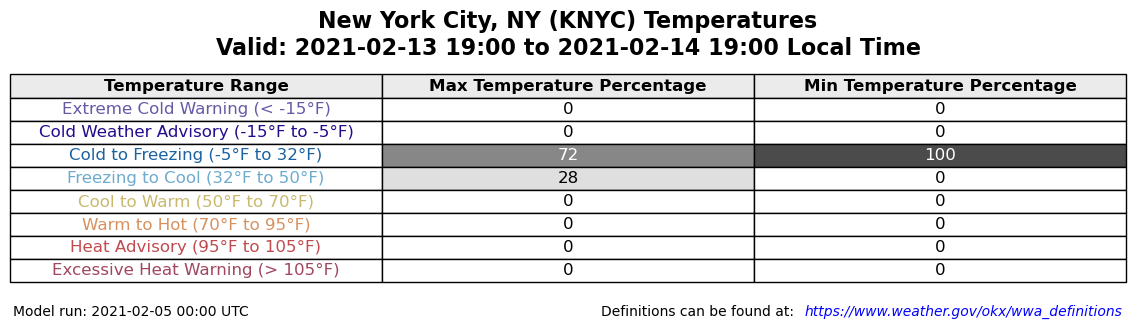

In [6]:
# Plot percentages in a table
plot_table(df, run_time)

## Example: 4/7/2024

In [18]:
# ---------------------------- Main ----------------------------

# User-defined model run to use
run_time = "2024-04-07 00:00"

# User-defined forecast period
start_hour = 216  # Specify the start forecast hour
end_hour = 240  # Specify the end forecast hour

# Get the temperatures over the forecast period
max_temps, min_temps = get_forecast_temperatures(run_time, start_hour, end_hour)

# Convert max and min temperatures to Fahrenheit
max_temps_f = kelvin_to_fahrenheit(max_temps)
min_temps_f = kelvin_to_fahrenheit(min_temps)

# Calculate the percentages of max and min temperatures in each range
max_percentages = calculate_percentages_in_ranges(max_temps_f, TEMP_RANGES)
min_percentages = calculate_percentages_in_ranges(min_temps_f, TEMP_RANGES)

# Prepare DataFrame for displaying the results
df = pd.DataFrame(list(max_percentages.items()), columns=["Temperature Range", "Max Temperature Percentage"])
df["Min Temperature Percentage"] = df["Temperature Range"].apply(
    lambda x: min_percentages[x] if x in min_percentages else 0
)

member:  p01
member:  p02


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


p02 failed at fxx=222: No valid message found: PosixPath('/Users/claytonsasaki/data/gefs/20240407/subset_19b78322__gep02.t00z.pgrb2a.0p50.f222')
member:  p03


/opt/anaconda3/envs/GEFS_plot/lib/python3.10/site-packages/herbie/core.py:1106: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


p03 failed at fxx=219: End of resource reached when reading message
member:  p04
member:  p05
member:  p06
member:  p07
member:  p08
member:  p09
member:  p10
member:  p11
member:  p12
member:  p13
member:  p14
member:  p15
member:  p16
member:  p17
member:  p18
member:  p19
member:  p20
member:  p21
member:  p22
member:  p23
member:  p24
member:  p25
member:  p26
member:  p27
member:  p28
member:  p29
member:  p30
member:  c00


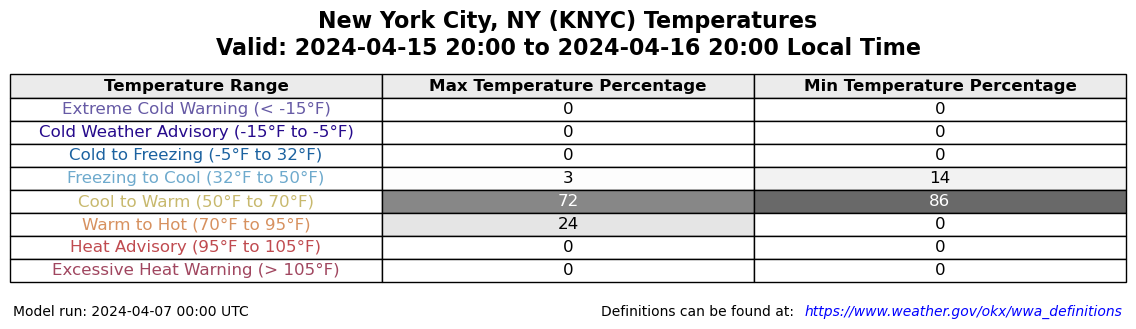

In [19]:
# Plot percentages in a table
plot_table(df, run_time)

## Example: 6/30/2021

In [20]:
# ---------------------------- Main ----------------------------

# User-defined model run to use
run_time = "2021-06-21 00:00"

# User-defined forecast period
start_hour = 216  # Specify the start forecast hour
end_hour = 240  # Specify the end forecast hour

# Get the temperatures over the forecast period
max_temps, min_temps = get_forecast_temperatures(run_time, start_hour, end_hour)

# Convert max and min temperatures to Fahrenheit
max_temps_f = kelvin_to_fahrenheit(max_temps)
min_temps_f = kelvin_to_fahrenheit(min_temps)

# Calculate the percentages of max and min temperatures in each range
max_percentages = calculate_percentages_in_ranges(max_temps_f, TEMP_RANGES)
min_percentages = calculate_percentages_in_ranges(min_temps_f, TEMP_RANGES)

# Prepare DataFrame for displaying the results
df = pd.DataFrame(list(max_percentages.items()), columns=["Temperature Range", "Max Temperature Percentage"])
df["Min Temperature Percentage"] = df["Temperature Range"].apply(
    lambda x: min_percentages[x] if x in min_percentages else 0
)

member:  p01
👨🏻‍🏭 Created directory: [/Users/claytonsasaki/data/gefs/20210621]
member:  p02
member:  p03
member:  p04
member:  p05
member:  p06
member:  p07
member:  p08
member:  p09
member:  p10
member:  p11
member:  p12
member:  p13
member:  p14
member:  p15
member:  p16
member:  p17
member:  p18
member:  p19
member:  p20
member:  p21
member:  p22
member:  p23
member:  p24
member:  p25
member:  p26
member:  p27
member:  p28
member:  p29
member:  p30
member:  c00


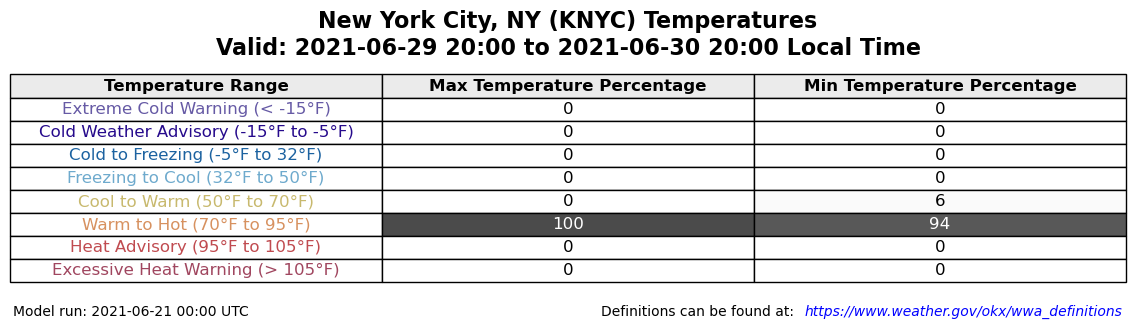

In [21]:
# Plot percentages in a table
plot_table(df, run_time)

## Example: 4/18/2025

In [22]:
# ---------------------------- Main ----------------------------

# User-defined model run to use
run_time = "2025-04-09 12:00"

# User-defined forecast period
start_hour = 216  # Specify the start forecast hour
end_hour = 240  # Specify the end forecast hour

# Get the temperatures over the forecast period
max_temps, min_temps = get_forecast_temperatures(run_time, start_hour, end_hour)

# Convert max and min temperatures to Fahrenheit
max_temps_f = kelvin_to_fahrenheit(max_temps)
min_temps_f = kelvin_to_fahrenheit(min_temps)

# Calculate the percentages of max and min temperatures in each range
max_percentages = calculate_percentages_in_ranges(max_temps_f, TEMP_RANGES)
min_percentages = calculate_percentages_in_ranges(min_temps_f, TEMP_RANGES)

# Prepare DataFrame for displaying the results
df = pd.DataFrame(list(max_percentages.items()), columns=["Temperature Range", "Max Temperature Percentage"])
df["Min Temperature Percentage"] = df["Temperature Range"].apply(
    lambda x: min_percentages[x] if x in min_percentages else 0
)

member:  p01
member:  p02
member:  p03
member:  p04
member:  p05
member:  p06
member:  p07
member:  p08
member:  p09
member:  p10
member:  p11
member:  p12
member:  p13
member:  p14
member:  p15
member:  p16
member:  p17
member:  p18
member:  p19
member:  p20
member:  p21
member:  p22
member:  p23
member:  p24
member:  p25
member:  p26
member:  p27
member:  p28
member:  p29
member:  p30
member:  c00


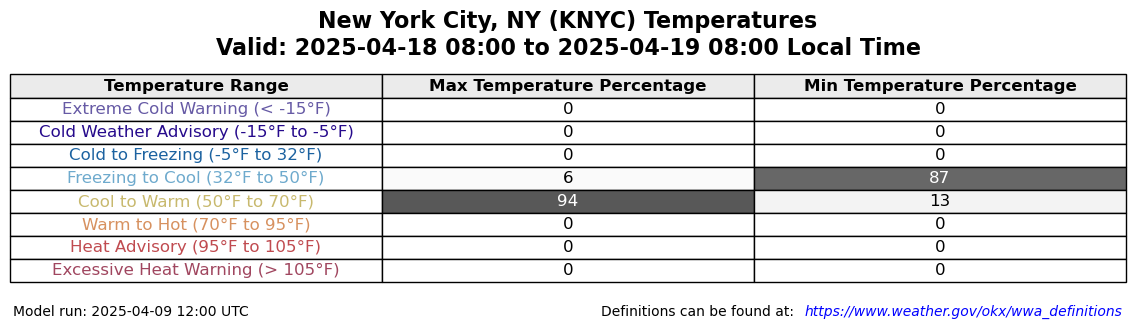

In [23]:
# Plot percentages in a table
plot_table(df, run_time)